<a href="https://colab.research.google.com/github/nv-hiep/nguyen_et_al_2019/blob/main/NHI_vs_NHIthin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import pickle

from tqdm import tqdm
from time import time
from PIL import Image

from astropy             import units      as u
from astropy.coordinates import SkyCoord


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# !pip install latex
# ! apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
# ! apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

# 2. Connect to Google Drive

In [4]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Jul 23 05:59:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [6]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019/
!ls

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019
CO					  images
fitted_parameters			  NHI_vs_NHIthin.ipynb
Haslam					  old
HI_decomposition_nguyen_et_al_2019.ipynb  scripts
HI_spectra				  Source_list.csv
HT03_data_and_the_fit.ipynb		  SPONGE
HT03_MS					  SPONGE_data_and_the_fit.ipynb


In [7]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019


## 3. Paths to Data Directories

In [8]:
PROJECT_PATH       = '/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019'
SPECTRA_PATH       = os.path.join( PROJECT_PATH, 'HI_spectra' )

FITTED_PARAMS_PATH = os.path.join( PROJECT_PATH, 'fitted_parameters' )
IMAGES_PATH        = os.path.join( PROJECT_PATH, 'images' )
PLOTS_PATH         = os.path.join( IMAGES_PATH, 'all_plots' )

CO_DATA            = os.path.join( PROJECT_PATH, 'CO' )

CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_Gaussian_parameters.fits' )
WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_Gaussian_parameters.fits' )

psV_CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_pseudoVoigt_parameters.fits' )
psV_WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_pseudoVoigt_parameters.fits' )

# 4. List of sources

In [9]:
df = pd.read_csv(os.path.join( PROJECT_PATH, 'Source_list.csv' ))
pd.set_option('display.max_rows', df.shape[0]+1)

In [10]:
df

,Source name,R.A (J2000),DEC (J2000),l(deg),b(deg),Flux(1.4GHz) in Jy,Tsky (K)
0,J034053+073525 (4C+07.13),03:40:53.73,07:35:25.40,178.87,-36.27,1.01,4.07
1,J032153+122114 (PKS0319+12),03:21:53.11,12:21:14.00,170.59,-36.24,1.91,4.51
2,J032723+120835 (4C+11.15),03:27:23.11,12:08:35.80,171.98,-35.48,1.21,4.17
3,J031857+162833 (4C+16.09),03:18:57.77,16:28:33.10,166.64,-33.60,8.03,6.93
4,J033626+130233 (3C090),03:36:26.56,13:02:33.20,173.15,-33.29,1.99,4.67
5,J035613+130535,03:56:13.81,13:05:35.80,177.02,-29.78,0.89,4.14
6,J035900+143622 (3C096),03:59:00.91,14:36:22.50,176.27,-28.26,1.20,4.37
7,J042725+085330 (4C+08.15),04:27:25.05,08:53:30.30,186.21,-26.51,0.94,4.08
8,J032504+244445 (4C+24.06),03:25:04.35,24:44:46,161.92,-26.26,0.81,4.13
9,J035633+190034 (4C+18.11),03:56:33.46,19:00:34.60,172.23,-25.66,1.05,4.15


In [11]:
# Number of sources, removed 2 sources
len(df) - 2

77

In [12]:
# df77 = df.drop([43, 45]).reset_index()
df77 = df.drop([43, 45])

In [13]:
df77['Name'] = df77['Source name'].str.split().apply( lambda x: x[1].strip().replace('(','').replace(')', '') if len(x) > 1 else x[0].strip() )

In [14]:
df77 = df77[ ['Source name', 'Name', 'R.A (J2000)', 'DEC (J2000)', 'l(deg)', 'b(deg)','Flux(1.4GHz) in Jy', 'Tsky (K)'] ]

In [15]:
df77

,Source name,Name,R.A (J2000),DEC (J2000),l(deg),b(deg),Flux(1.4GHz) in Jy,Tsky (K)
0,J034053+073525 (4C+07.13),4C+07.13,03:40:53.73,07:35:25.40,178.87,-36.27,1.01,4.07
1,J032153+122114 (PKS0319+12),PKS0319+12,03:21:53.11,12:21:14.00,170.59,-36.24,1.91,4.51
2,J032723+120835 (4C+11.15),4C+11.15,03:27:23.11,12:08:35.80,171.98,-35.48,1.21,4.17
3,J031857+162833 (4C+16.09),4C+16.09,03:18:57.77,16:28:33.10,166.64,-33.60,8.03,6.93
4,J033626+130233 (3C090),3C090,03:36:26.56,13:02:33.20,173.15,-33.29,1.99,4.67
5,J035613+130535,J035613+130535,03:56:13.81,13:05:35.80,177.02,-29.78,0.89,4.14
6,J035900+143622 (3C096),3C096,03:59:00.91,14:36:22.50,176.27,-28.26,1.20,4.37
7,J042725+085330 (4C+08.15),4C+08.15,04:27:25.05,08:53:30.30,186.21,-26.51,0.94,4.08
8,J032504+244445 (4C+24.06),4C+24.06,03:25:04.35,24:44:46,161.92,-26.26,0.81,4.13
9,J035633+190034 (4C+18.11),4C+18.11,03:56:33.46,19:00:34.60,172.23,-25.66,1.05,4.15


In [16]:
src_names = df77['Name'].to_numpy().tolist()
src_names[:8]

['4C+07.13',
 'PKS0319+12',
 '4C+11.15',
 '4C+16.09',
 '3C090',
 'J035613+130535',
 '3C096',
 '4C+08.15']

# 5. Data and information of 3C138

In [17]:
# Select a source
src       = '3C138'
file_path = os.path.join( SPECTRA_PATH, src + '.fits' )

Read the data

In [18]:
data, header = fits.getdata(file_path, header=True)
for x in header:
    print(x, header[x])

XTENSION BINTABLE
BITPIX 8
NAXIS 2
NAXIS1 88
NAXIS2 1118
PCOUNT 0
GCOUNT 1
TFIELDS 11
TTYPE1 vlsr_tau
TFORM1 D
TUNIT1 km/s
TTYPE2 emt
TFORM2 D
TTYPE3 sigemt
TFORM3 D
TTYPE4 vlsr_fitcnm
TFORM4 D
TUNIT4 km/s
TTYPE5 fitcnm
TFORM5 D
TTYPE6 vlsr_TB
TFORM6 D
TUNIT6 km/s
TTYPE7 TB
TFORM7 D
TUNIT7 K
TTYPE8 sigTB
TFORM8 D
TUNIT8 K
TTYPE9 TB_tot_fit
TFORM9 D
TUNIT9 K
TTYPE10 TB_WNM_fit
TFORM10 D
TUNIT10 K
TTYPE11 TB_CNM_fit
TFORM11 D
TUNIT11 K


In [19]:
data.__dict__

{'_character_as_bytes': False,
 '_col_weakrefs': <_weakrefset.WeakSet at 0x7fb5e263dd10>,
 '_coldefs': ColDefs(
     name = 'vlsr_tau'; format = 'D'; unit = 'km/s'
     name = 'emt'; format = 'D'
     name = 'sigemt'; format = 'D'
     name = 'vlsr_fitcnm'; format = 'D'; unit = 'km/s'
     name = 'fitcnm'; format = 'D'
     name = 'vlsr_TB'; format = 'D'; unit = 'km/s'
     name = 'TB'; format = 'D'; unit = 'K'
     name = 'sigTB'; format = 'D'; unit = 'K'
     name = 'TB_tot_fit'; format = 'D'; unit = 'K'
     name = 'TB_WNM_fit'; format = 'D'; unit = 'K'
     name = 'TB_CNM_fit'; format = 'D'; unit = 'K'
 ),
 '_converted': {},
 '_gap': 0,
 '_heapoffset': 98384,
 '_heapsize': 0,
 '_nfields': 11,
 '_uint': True}

In [20]:
hdr = fits.getheader(file_path)
for x in hdr:
    print(x, hdr[x])

SIMPLE True
BITPIX 8
NAXIS 0
EXTEND True
V1 -100.0
V2 -70.0
V3 50.0
V4 80.0
GLON 187.40518
GLAT -11.34306
RA50 5.30462
DEC50 16.59082
NAME 3C138
NICKNAME SRC1_T
NCNM 7
NWNM 3
N(HI) 22.57762727624125
sig_N(HI) 0.5323630889923695
N(HI)_thin 19.80436752445369
sig_N(HI)_thin 0.05409405767166584
N(HI)_CNM_sum 12.3600589697927
sig_N(HI)_CNM_sum 0.3680022641427338
N(HI)_WNM_sum 10.21756830644855
sig_N(HI)_WNM_sum 0.3846879152083141
sigfit_CNM 0.004273500718419046
sigfit_WNM 0.4425469101660937
FLUX 8.6029
TSKY 7.58776171875
TSKY_FIT 7.569012594355987
EMTNOISE 0.002956991602897381
TB_NOISE 0.2100233998072635
TELE Arecibo
CMT1 Nguyen et al. 2019
CMT2 V1 < V2 < V3 < V4 (km/s), VLSR ranges for baseline, the spectral lines in [v2,v3]
CMT3 Ra50 [hour]
CMT4 emtnoise = Noise level of EMT spectrum [NONE]
CMT5 TB_noise = Noise level of T_exp spectrum [K]
CMT6 Flux = Flux at 21 cm [Jy]
CMT7 Tsky, Tsky_fit are Tsky and Tsky obtained from the fit (Tsky is also considered as a parameter to fit)


In [21]:
hdr.__dict__

{'_cards': [('SIMPLE', True, 'conforms to FITS standard'),
  ('BITPIX', 8, 'array data type'),
  ('NAXIS', 0, 'number of array dimensions'),
  ('EXTEND', True, ''),
  ('V1', -100.0, ''),
  ('V2', -70.0, ''),
  ('V3', 50.0, ''),
  ('V4', 80.0, ''),
  ('GLON', 187.40518, ''),
  ('GLAT', -11.34306, ''),
  ('RA50', 5.30462, ''),
  ('DEC50', 16.59082, ''),
  ('NAME', '3C138', ''),
  ('NICKNAME', 'SRC1_T', ''),
  ('NCNM', 7, ''),
  ('NWNM', 3, ''),
  ('N(HI)', 22.57762727624125, ''),
  ('sig_N(HI)', 0.5323630889923695, ''),
  ('N(HI)_thin', 19.80436752445369, ''),
  ('sig_N(HI)_thin', 0.05409405767166584, ''),
  ('N(HI)_CNM_sum', 12.3600589697927, ''),
  ('sig_N(HI)_CNM_sum', 0.3680022641427338, ''),
  ('N(HI)_WNM_sum', 10.21756830644855, ''),
  ('sig_N(HI)_WNM_sum', 0.3846879152083141, ''),
  ('sigfit_CNM', 0.004273500718419046, ''),
  ('sigfit_WNM', 0.4425469101660937, ''),
  ('FLUX', 8.6029, ''),
  ('TSKY', 7.58776171875, ''),
  ('TSKY_FIT', 7.569012594355987, ''),
  ('EMTNOISE', 0.002956

## 5.1 Information

### 5.1.1 For $\tau$

In [22]:
# Velocity axis: 'vlsr_tau'; format = 'D'; unit = 'km/s'
data['vlsr_tau']

array([ 79.86933482,  79.70830794,  79.54728105, ..., -99.67564164,
       -99.83666853, -99.99769541])

In [23]:
# e(-tau): 'emt'; format = 'D'
data['emt']

array([0.99296588, 0.99876756, 0.99741992, ..., 1.00050112, 0.99667971,
       1.00140136])

In [24]:
# sigma of e(-tau): 'sigemt'; format = 'D'
data['sigemt']

array([0.0040176 , 0.00309521, 0.00439645, ..., 0.00442881, 0.00373374,
       0.00295681])

In [25]:
# Velocity axis of the fit: 'vlsr_fitcnm'; format = 'D'; unit = 'km/s'
data['vlsr_fitcnm'] # Same as data['vlsr_tau']

array([ 79.86933482,  79.70830794,  79.54728105, ..., -99.67564164,
       -99.83666853, -99.99769541])

In [26]:
# The fit to the CNM: 'fitcnm'; format = 'D'
data['fitcnm']

array([1., 1., 1., ..., 1., 1., 1.])

### 5.1.2 For $T_\mathrm{exp} [K]$

In [27]:
# Velocity axis 'vlsr_TB'; format = 'D'; unit = 'km/s'
data['vlsr_TB'] # Same as data['vlsr_tau']

array([ 79.86933482,  79.70830794,  79.54728105, ..., -99.67564164,
       -99.83666853, -99.99769541])

In [28]:
# T_exp: 'TB'; format = 'D'; unit = 'K'
data['TB']

array([ 0.43916686, -0.11692797,  0.40419592, ...,  0.01501079,
        0.17440877,  0.23447064])

In [29]:
# Sigma of T_exp: 'sigTB'; format = 'D'; unit = 'K'
data['sigTB']

array([0.46904768, 0.3522479 , 0.51634632, ..., 0.52037445, 0.43339965,
       0.3344131 ])

In [30]:
# Total fit to T_exp: 'TB_tot_fit'; format = 'D'; unit = 'K'
data['TB_tot_fit']

array([4.85500520e-08, 5.25041015e-08, 5.67709950e-08, ...,
       2.29393798e-04, 2.19607208e-04, 2.10217035e-04])

In [31]:
# Total contribution to T_exp from the WNM: 'TB_WNM_fit'; format = 'D'; unit = 'K'
data['TB_WNM_fit']

array([4.85500520e-08, 5.25041015e-08, 5.67709951e-08, ...,
       2.29393798e-04, 2.19607208e-04, 2.10217035e-04])

In [32]:
# Total contribution to T_exp from the CNM: 'TB_CNM_fit'; format = 'D'; unit = 'K'
data['TB_CNM_fit']

array([0., 0., 0., ..., 0., 0., 0.])

### 5.1.3 Other infor and Results

In [33]:
# V1 < V2 < V3 < V4 (km/s), VLSR ranges for baseline, the spectral lines in [v2,v3], Unit: km/s
print( hdr['V1'], hdr['V2'], hdr['V3'], hdr['V4'] )

-100.0 -70.0 50.0 80.0


In [34]:
# Galactic Longitude and lattitude, Unit: Degree
print(hdr['GLON'], hdr['GLAT'])

187.40518 -11.34306


In [35]:
# Right Ascension and Declination, Units: Ra50 [hour], DEC50 [degree]
print(hdr['RA50'], hdr['DEC50'])

5.30462 16.59082


In [36]:
# Name and nickname of the source
print(hdr['NAME'], hdr['NICKNAME'])

3C138 SRC1_T


In [37]:
# Numbers of CNM components and WNM components used for the fit
print('NCNM: ', hdr['NCNM'])
print('NWNM: ', hdr['NWNM'])

NCNM:  7
NWNM:  3


In [38]:
# Result of N(HI): HI column density, Unit: 1e20 [H cm^-2]
print('N(HI): ', hdr['N(HI)'])
print('sig_N(HI): ', hdr['sig_N(HI)'])

N(HI):  22.57762727624125
sig_N(HI):  0.5323630889923695


In [39]:
# Result of N*(HI): HI column density under optically thin assumption, Unit: 1e20 [H cm^-2]
print('N(HI)_thin: ', hdr['N(HI)_thin'])
print('sig_N(HI)_thin: ', hdr['sig_N(HI)_thin'])

N(HI)_thin:  19.80436752445369
sig_N(HI)_thin:  0.05409405767166584


In [40]:
# Result of N(HI)_CNM_sum: The contribution of CNM to the N(HI), Unit: 1e20 [H cm^-2]
print('N(HI)_CNM_sum: ', hdr['N(HI)_CNM_sum'])
print('sig_N(HI)_CNM_sum: ', hdr['sig_N(HI)_CNM_sum'])

N(HI)_CNM_sum:  12.3600589697927
sig_N(HI)_CNM_sum:  0.3680022641427338


In [41]:
# Result of N(HI)_WNM_sum: The contribution of WNM to the N(HI), Unit: 1e20 [H cm^-2]
print('N(HI)_WNM_sum: ', hdr['N(HI)_WNM_sum'])
print('sig_N(HI)_WNM_sum: ', hdr['sig_N(HI)_WNM_sum'])

N(HI)_WNM_sum:  10.21756830644855
sig_N(HI)_WNM_sum:  0.3846879152083141


In [42]:
# Flux at 21 cm [Jy]
hdr['FLUX']

8.6029

In [43]:
# Tsky [K], Tsky_fit [K] are Tsky and Tsky obtained from the fit (Tsky is also considered as a parameter to fit)
print('T_SKY: ', hdr['TSKY'])
print('T_SKY_FIT: ',  hdr['TSKY_FIT'])

T_SKY:  7.58776171875
T_SKY_FIT:  7.569012594355987


# 6. N(HI) and N*(HI) for all sources

N(HI): "True" HI column density

N*(HI): HI column density under optically-thin assumption

In [44]:
## Calculate the uncertainties of ratio a/b #
 #
 # params float a
 # params float b
 # params float aer
 # params float ber
 #
 # return float ret Uncertainty of a/b
 # 
 # Author Van Hiep ##
def uncertainty_of_ratio(a, b, aer, ber):
	r  = np.abs(a/b)
	d1 = aer
	d1 = d1*d1

	d2 = r*ber
	d2 = d2*d2

	return np.abs(1./b) * np.sqrt(d1+d2)

In [45]:
## Read W(CO) map #
 #
 # params string file   Filename
 # params list   lonra  Range of Glong
 # params list   latra  Range of Glat
 # params string cloud  cloud: Taurus or Rosette
 #
 # return string path to file
 # 
 # version 7/2018
 # Author Van Hiep ##
def read_wco_map(file, lonra=[], latra=[], cloud=None):
	hdulist  = fits.open(file)

	## data and header: hdulist[0].data[:, ::-1]
	data     = hdulist[0].data
	data     = np.swapaxes(data, 0, 1)
	header   = hdulist[0].header

	## Infor of data files
	naxis    = header['NAXIS']
	naxis1   = header['NAXIS1']
	naxis2   = header['NAXIS2']


	## GLONG
	ctype1   = header['CTYPE1']
	xref_val = header['CRVAL1']
	xref_pix = header['CRPIX1']
	xdelt    = header['CDELT1']

	a1       = xdelt
	b1       = xref_val - a1*xref_pix

	xindx    = np.array( range(naxis1) )
	gl       = xindx*a1 + b1

	## GLAT
	ctype2   = header['CTYPE2']
	yref_val = header['CRVAL2']
	yref_pix = header['CRPIX2']
	ydelt    = header['CDELT2']
	
	a2       = ydelt
	b2       = yref_val - a2*yref_pix
	
	yindx    = np.array( range(naxis2) )
	gb       = yindx*a2 + b2
	## END - Headers

	if(cloud == None):
		GL, GB = np.meshgrid(gl, gb, indexing='ij')
		return GL, GB, data
	## Endif
	
	idx    = np.where( (gl > lonra[0]) & (gl < lonra[1]) ) [0]
	idy    = np.where( (gb > latra[0]) & (gb < latra[1]) ) [0]

	gl     = gl[idx]
	gb     = gb[idy]
	GL, GB = np.meshgrid(gl, gb, indexing='ij')
	data   = data[ idx[0]:idx[-1]+1, idy[0]:idy[-1]+1 ]


	## Write to file
	# ret            = {}
	# ret['RA2000']  = RA2K  # in degree
	# ret['DEC2000'] = DEC2K
	# ret['ell']     = gl
	# ret['bee']     = gb
	# ret['thin']    = gfthin
	# ret['sigthin'] = gfsigthin
	# ret['nhi']     = gfnhi
	# np.save(filepath, ret)

	return gl, gb, GL, GB, data

In [46]:
# Read CO data
X, Y, wco = read_wco_map( os.path.join(CO_DATA, 'mlat+fermi+DHT_Wco_mom.fits') )

In [47]:
nsrc = len(src_names)
print(f'Number of sources: {nsrc}')

Number of sources: 77


In [ ]:
gl  = np.zeros(nsrc)
gb  = np.zeros(nsrc)
ra  = np.zeros(nsrc)
dec = np.zeros(nsrc)

nhi     = np.zeros(nsrc)
signhi  = np.zeros(nsrc)
thin    = np.zeros(nsrc)
sigthin = np.zeros(nsrc)

for (i, src) in enumerate(src_names):
  hdr = fits.getheader( os.path.join( SPECTRA_PATH, src + '.fits' ) )

  print('> Source id = %d, name = %s'%(i,src) )

  if i == 0:
    # Galactic Longitude and lattitude, Unit: Degree
    print(f"Galactic l,b = ({hdr['GLON']},{hdr['GLAT']}) (degree, degree)")

    # Right Ascension and Declination, Units: Ra50 [hour], DEC50 [degree]
    print(f"RADEC1950 = ({hdr['RA50']},{hdr['DEC50']}) (hour, degree)")
    
    # Result of N(HI): HI column density, Unit: 1e20 [H cm^-2]
    print('N(HI): ', hdr['N(HI)'])
    print('sig_N(HI): ', hdr['sig_N(HI)'])

    # Result of N*(HI): HI column density under optically thin assumption, Unit: 1e20 [H cm^-2]
    print('N(HI)_thin: ', hdr['N(HI)_thin'])
    print('sig_N(HI)_thin: ', hdr['sig_N(HI)_thin'])
  # End - if

  gb[i]  = hdr['GLAT']
  gl[i]  = hdr['GLON']
  ra[i]  = hdr['RA50']
  dec[i] = hdr['DEC50']

  nhi[i]     = hdr['N(HI)']
  signhi[i]  = hdr['sig_N(HI)']
  thin[i]    = hdr['N(HI)_thin']
  sigthin[i] = hdr['sig_N(HI)_thin']

  print( ('-')*10 )

In [49]:
df77['l'] = gl.copy()
df77['b'] = gb.copy()

df77['RA1950']  = ra.copy()
df77['DEC1950'] = dec.copy()

df77['NHI']    = nhi.copy()
df77['sigNHI'] = signhi.copy()

df77['NHI_thin']    = thin.copy()
df77['sigNHI_thin'] = signhi.copy()

In [50]:
ratio   = nhi/thin
sigrat  = uncertainty_of_ratio(nhi, thin, signhi, sigthin)

In [51]:
df77['ratio'] = ratio.copy()
df77['sigratio'] = sigrat.copy()

In [52]:
df77.columns

Index(['Source name', 'Name', 'R.A (J2000)', 'DEC (J2000)', 'l(deg)', 'b(deg)',
       'Flux(1.4GHz) in Jy', 'Tsky (K)', 'l', 'b', 'RA1950', 'DEC1950', 'NHI',
       'sigNHI', 'NHI_thin', 'sigNHI_thin', 'ratio', 'sigratio'],
      dtype='object')

In [53]:
df77.drop(['Source name', 'Flux(1.4GHz) in Jy', 'l(deg)', 'b(deg)'], axis=1, inplace=True)

In [54]:
df77

,Name,R.A (J2000),DEC (J2000),Tsky (K),l,b,RA1950,DEC1950,NHI,sigNHI,NHI_thin,sigNHI_thin,ratio,sigratio
0,4C+07.13,03:40:53.73,07:35:25.40,4.07,178.87378,-36.270190,3.636900,7.430240,16.571832,0.889309,13.690089,0.889309,1.210499,0.065049
1,PKS0319+12,03:21:53.11,12:21:14.00,4.51,170.59078,-36.237390,3.318950,12.175510,32.668423,1.169880,16.028992,1.169880,2.038083,0.073158
2,4C+11.15,03:27:23.11,12:08:35.80,4.17,171.98257,-35.477250,3.410620,11.969960,24.286359,0.669429,16.720618,0.669429,1.452480,0.040240
3,4C+16.09,03:18:57.77,16:28:33.10,6.93,166.63557,-33.595820,3.269200,16.294670,12.289798,0.709471,10.662962,0.709471,1.152569,0.066757
4,3C090,03:36:26.56,13:02:33.20,4.67,173.15110,-33.294970,3.561230,12.878010,28.493619,1.930725,16.550664,1.930725,1.721600,0.116724
5,J035613+130535,03:56:13.81,13:05:35.80,4.14,177.02374,-29.782330,3.890810,12.948570,17.246395,0.437157,13.166882,0.437157,1.309831,0.033493
6,3C096,03:59:00.91,14:36:22.50,4.37,176.26624,-28.263350,3.936760,14.464410,20.149291,0.980017,15.291777,0.980017,1.317655,0.064163
7,4C+08.15,04:27:25.05,08:53:30.30,4.08,186.20813,-26.513890,4.411620,8.780810,17.575122,0.561081,13.260399,0.561081,1.325384,0.042587
8,4C+24.06,03:25:04.35,24:44:46,4.13,161.92015,-26.262150,3.368560,24.570490,10.288009,0.378952,9.339067,0.378952,1.101610,0.040933
9,4C+18.11,03:56:33.46,19:00:34.60,4.15,172.22662,-25.660040,3.894480,18.865230,14.398572,1.302620,12.496213,1.302620,1.152235,0.104290


In [ ]:
# Indices for each region
idxin = np.where( (gb > -5.) & (gb < 4.5) )[0]
idxup = np.where( gb > 4.5 )[0]
idxlo = np.where( gb < -5. )[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log10


plot: Perseus
plot: Mon OB1
plot: NGC 2264
plot: Rosette
plot: Taurus
plot: California


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


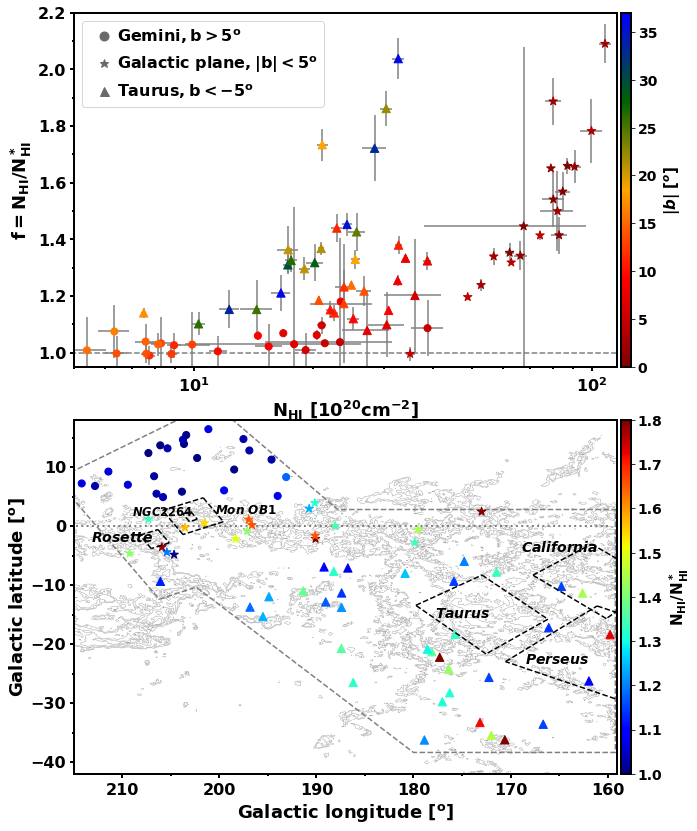

In [63]:
## PLOT - ratio vs thin  for all soures ##
fts   = 18
lbsz  = 16
lgds  = 16
txtfs = 14

plt.rc('font', weight='bold')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
mpl.rcParams['axes.linewidth']      = 2.

## Make a color bar
# colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # R -> G -> B
# colors = ['blue', 'darkgreen', 'r', 'maroon']
colors = ['blue', 'darkgreen', 'orange', 'r', 'maroon']
colors = colors[::-1]
n_bins = 500
cm     = mpl.colors.LinearSegmentedColormap.from_list('my_cbar', colors, N=n_bins) # cm = mpl.cm.get_cmap('jet_r')


## figures
fig, axs = plt.subplots( 2, 1, figsize=(10,14) )
axes     = axs.flatten()


## Subplot
ax = axs[0]
# major_xticks = np.arange(0., 500., 10.)
# minor_xticks = np.arange(0., 500., 10.)
major_yticks = np.arange(0.6, 2.6, 0.2)
minor_yticks = np.arange(0.6, 2.6, 0.1)

ax.errorbar(nhi, ratio, xerr=signhi, yerr=sigrat, zorder=1,  color='k', marker='o', ls='None', markersize=2, markeredgecolor='k', markeredgewidth=1, ecolor='gray', label='')
sct1 = ax.scatter(nhi[idxin], ratio[idxin], zorder=2, s=80, c=np.abs(gb[idxin]), marker='*', cmap=cm, vmin=0., vmax=37., label='')
sct2 = ax.scatter(nhi[idxup], ratio[idxup], zorder=2, s=50, c=np.abs(gb[idxup]), marker='o', cmap=cm, vmin=0., vmax=37., label='')
sct2 = ax.scatter(nhi[idxlo], ratio[idxlo], zorder=2, s=70, c=np.abs(gb[idxlo]), marker='^', cmap=cm, vmin=0., vmax=37., label='')

# plot lines that have the same formating as the histograms
ax.plot([0.], [0.], color='dimgrey', markersize=9, marker='o', ls='None', label=r'$\mathrm{Gemini, b > 5^{o}}$')
ax.plot([0.], [0.], color='dimgrey', markersize=9, marker='*', ls='None', label=r'$\mathrm{Galactic\ plane, |b| < 5^{o}}$')
ax.plot([0.], [0.], color='dimgrey', markersize=9, marker='^', ls='None', label=r'$\mathrm{Taurus, b < -5^{o}}$')


ax.plot([0.,150.], [1.,1.], zorder=0, color='gray', ls='--', lw=1.5)

ax.set_xlabel(r'$\mathrm{N_{HI}\ [10^{20} cm^{-2}]}$', fontsize=fts, fontweight='normal')
ax.set_ylabel(r'$\mathrm{f=N_{HI}/N^*_{HI}}$', fontsize=fts, fontweight='normal')

ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)

ax.tick_params(axis='x', labelsize=lbsz, pad=5)
ax.tick_params(axis='y', labelsize=lbsz)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.grid(False)

ax.set_xscale('log')

ax.set_xlim(5., 116.)
ax.set_ylim(0.95, 2.2)

# Legend
ax.legend(loc='upper left', fontsize=lgds, handletextpad=-0.2, numpoints=1)


## Color bar
cbar = fig.colorbar(sct1, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|\ [^{o}]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

## set invisible
# sct.set_visible(False)











### Axes2
ax = axs[1]
## Make a color bar
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # R -> G -> B
colors = ['blue', 'darkgreen', 'r', 'maroon']
colors = ['blue', 'cyan', 'orange', 'red']
n_bins = 500
cm     = mpl.colors.LinearSegmentedColormap.from_list('my_cbar', colors, N=n_bins)

major_xticks = np.arange(160., 215., 10.)
minor_xticks = np.arange(160., 215., 5.)
major_yticks = np.arange(-40., 20., 10.)
minor_yticks = np.arange(-40., 20., 5.)

sct  = ax.scatter(gl[idxin], gb[idxin], zorder=0, s=80, c=ratio[idxin], marker='*', cmap='jet', vmin=1., vmax=1.8, label='')
sct  = ax.scatter(gl[idxup], gb[idxup], zorder=0, s=50, c=ratio[idxup], marker='o', cmap='jet', vmin=1., vmax=1.8, label='')
sct  = ax.scatter(gl[idxlo], gb[idxlo], zorder=0, s=70, c=ratio[idxlo], marker='^', cmap='jet', vmin=1., vmax=1.8, label='')

ax.plot([160., 215.], [0., 0.], zorder=-1, color='grey', ls=':', lw=2)

## CO contours
clvl = [0.01, 0.5, 1.1, 1.5, 1.75]
ax.contour(X, Y, np.log10(wco), clvl, zorder=-1, colors='darkgrey', linestyles='solid', linewidths=0.5)


ax.plot([216.8, 200.7, 187.8, 159.2, 159.2, 180., 202.39, 206.2, 216.8], [7.9, 20.9, 2.8, 2.8, -38.38, -38.38, -10.36, -12.4, 7.9], color='grey', ls='--', zorder=-1)

## Plot clouds
print('plot: Perseus')
ralimp  = [4., 4., 2., 2.] 
declimp = [22., 35., 35., 22.]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[0]-2., gbx[0]-0.4, '$Perseus$', fontsize=txtfs )



print('plot: Mon OB1')
ralimp  = [6.8, 6.8, 6.49, 6.49] 
declimp = [7.5, 12.2, 12.2, 7.5]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[2]+0.9, gbx[2]+1.3, r'$Mon\ OB1$', fontsize=txtfs-2 )



print( 'plot: NGC 2264')
ralimp  = [6.7, 6.7, 6.6, 6.6] 
declimp = [9.1, 10., 10., 9.1]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[0]+5.2, gbx[0]-0.25, '$NGC 2264$', fontsize=txtfs-2.5 )



print( 'plot: Rosette')
ralimp  = [6.62, 6.62, 6.45, 6.45] 
declimp = [3.5, 5.6, 5.6, 3.5]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[0]+5., gbx[0]-1., '$Rosette$', fontsize=txtfs )



print( 'plot: Taurus')
ralimp  = [4.93, 4.93, 4.16, 4.16] 
declimp = [21.57, 30., 30., 21.57]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[0]-2., gbx[0]-2., '$Taurus$', fontsize=txtfs )



print( 'plot: California')
ralimp  = [4.67, 4.67, 3.83, 3.83] 
declimp = [34., 42., 42., 34.]

c   = SkyCoord(ra = ralimp*u.hour, dec = declimp*u.degree)
gal = c.galactic
glx = gal.l.degree
gbx = gal.b.degree
plt.plot( [glx[0], glx[1]], [gbx[0], gbx[1]], 'k--', label='')
plt.plot( [glx[1], glx[2]], [gbx[1], gbx[2]], 'k--')
plt.plot( [glx[2], glx[3]], [gbx[2], gbx[3]], 'k--')
plt.plot( [glx[3], glx[0]], [gbx[3], gbx[0]], 'k--')
ax.text( glx[0]+1.25, gbx[0]+4., '$California$', fontsize=txtfs )
## ENd - Clouds



ax.set_ylabel(r'$\mathrm{Galactic\ latitude\ [^{o}]}$', fontsize=fts, fontweight='normal')
ax.set_xlabel(r'$\mathrm{Galactic\ longitude\ [^{o}]}$', fontsize=fts, fontweight='normal')

ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)

ax.tick_params(axis='x', labelsize=lbsz, pad=5)
ax.tick_params(axis='y', labelsize=lbsz)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)
ax.grid(False)

ax.set_xlim(215., 159.)
ax.set_ylim(-42., 18.)

## Legend
# plt.legend(loc='lower left', fontsize=lgds, handletextpad=-0.2, numpoints=1)

plt.subplots_adjust(wspace=None, hspace=0.15)


## Color bar
cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{N_{HI}/N^*_{HI}}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.savefig( os.path.join(IMAGES_PATH, 'ratio_vs_nhi.eps'), bbox_inches='tight', pad_inches=0.08, format='eps', dpi=40)

plt.show()